In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
import re
from sklearn.metrics import r2_score

In [2]:
df_health = pd.read_csv('./data/DCCV_AVQ_PERSONE_26022019105130683.csv')
df_sports = pd.read_csv('./data/DCCV_AVQ_PERSONE_26022019105432017.csv')

In [3]:
REGION_CODE_COL = 'ITTER107'
REGION_CODE_COL_INCOME = 'IT107'
REGION_NAME_COL = 'Territory'

MEASURE_OF_INTEREST = 'Measure'
MEASURE_OF_INTEREST_PERCENT = 'per 100 people with the same characteristics'

VALUES_OF_INTEREST_COL = 'Value'
VALUE_CATEGORIES_COL = 'Data type'

MULTI_INDEX = [REGION_NAME_COL]
DROP_COLUMNS = [REGION_CODE_COL, 'TIPO_DATO_AVQ', 'Measure', 'Select time', 'MISURA_AVQ', 'TIME']
DROP_COLUMNS_INCOME = [REGION_CODE_COL_INCOME, 'TIPO_DATO_AVQ', 'Measure', 'Select time', 'MISURA_AVQ']

HEALTH_CONDITIONS = df_health[VALUE_CATEGORIES_COL].unique()
SPORT_LEVELS = np.array([
    '{} physical activity'.format(how_much)
    for how_much in ['No', 'Low', 'Moderate', 'Intense']
])

SPORTS_COLUMNS = {
    'never': SPORT_LEVELS[0],
    'some type of physical activity': SPORT_LEVELS[1],
    'occasionally': SPORT_LEVELS[2],
    'continuosly': SPORT_LEVELS[3],
}

# We're filtering only regions.
# The dataframes also contain aggregate macro-region and national data.

region_codes = [
    c for c in df_health[REGION_CODE_COL].unique()
    if re.match('^(?!ITD[12])IT(.\d|DA)', c)
]

In [4]:
# Cleaning up and reformatting data

def remove_after_slash(s):
    return s[:s.find(' / ')] if ' / ' in s else s

df_health['Territory'] = df_health['Territory'].apply(remove_after_slash)
df_health_2016 = (
    df_health[
        (df_health[REGION_CODE_COL].isin(region_codes)) &
        (df_health[MEASURE_OF_INTEREST] == MEASURE_OF_INTEREST_PERCENT) & 
        (df_health['TIME'] == 2016)
    ]
    .set_index(MULTI_INDEX, drop=True)
    .dropna(axis=1)
    .drop(DROP_COLUMNS, axis=1)
)

df_health_2016 = df_health_2016.pivot_table(
    values=VALUES_OF_INTEREST_COL, columns=VALUE_CATEGORIES_COL,
    index=df_health_2016.index, aggfunc='first'
)

df_health_2017 = (
    df_health[
        (df_health[REGION_CODE_COL].isin(region_codes)) &
        (df_health[MEASURE_OF_INTEREST] == MEASURE_OF_INTEREST_PERCENT) & 
        (df_health['TIME'] == 2017)
    ]
    .set_index(MULTI_INDEX, drop=True)
    .dropna(axis=1)
    .drop(DROP_COLUMNS, axis=1)
)

df_health_2017 = df_health_2017.pivot_table(
    values=VALUES_OF_INTEREST_COL, columns=VALUE_CATEGORIES_COL,
    index=df_health_2017.index, aggfunc='first'
)


df_sports['Territory'] = df_sports['Territory'].apply(remove_after_slash)
df_sports = (
    df_sports[
        (df_sports[REGION_CODE_COL].isin(region_codes)) &
        (df_sports[MEASURE_OF_INTEREST] == MEASURE_OF_INTEREST_PERCENT) & 
        (df_sports['TIME'] == 2016)
    ]
    .set_index(MULTI_INDEX, drop=True)
    .dropna(axis=1)
    .drop(DROP_COLUMNS, axis=1)
)

df_sports = df_sports.pivot_table(
    values=VALUES_OF_INTEREST_COL, columns=VALUE_CATEGORIES_COL,
    index=df_sports.index, aggfunc='first'
)

df_sports.rename(columns = SPORTS_COLUMNS, inplace=True)

In [5]:
df_sports = df_sports / df_sports.mean()
# df_health = df_health / df_health.mean()
df_health_delta = (df_health_2017 - df_health_2016) / df_health_2016.mean()

In [6]:
# Merge 
df = pd.merge(df_health_delta, df_sports, left_index=True, right_index=True, how='inner')

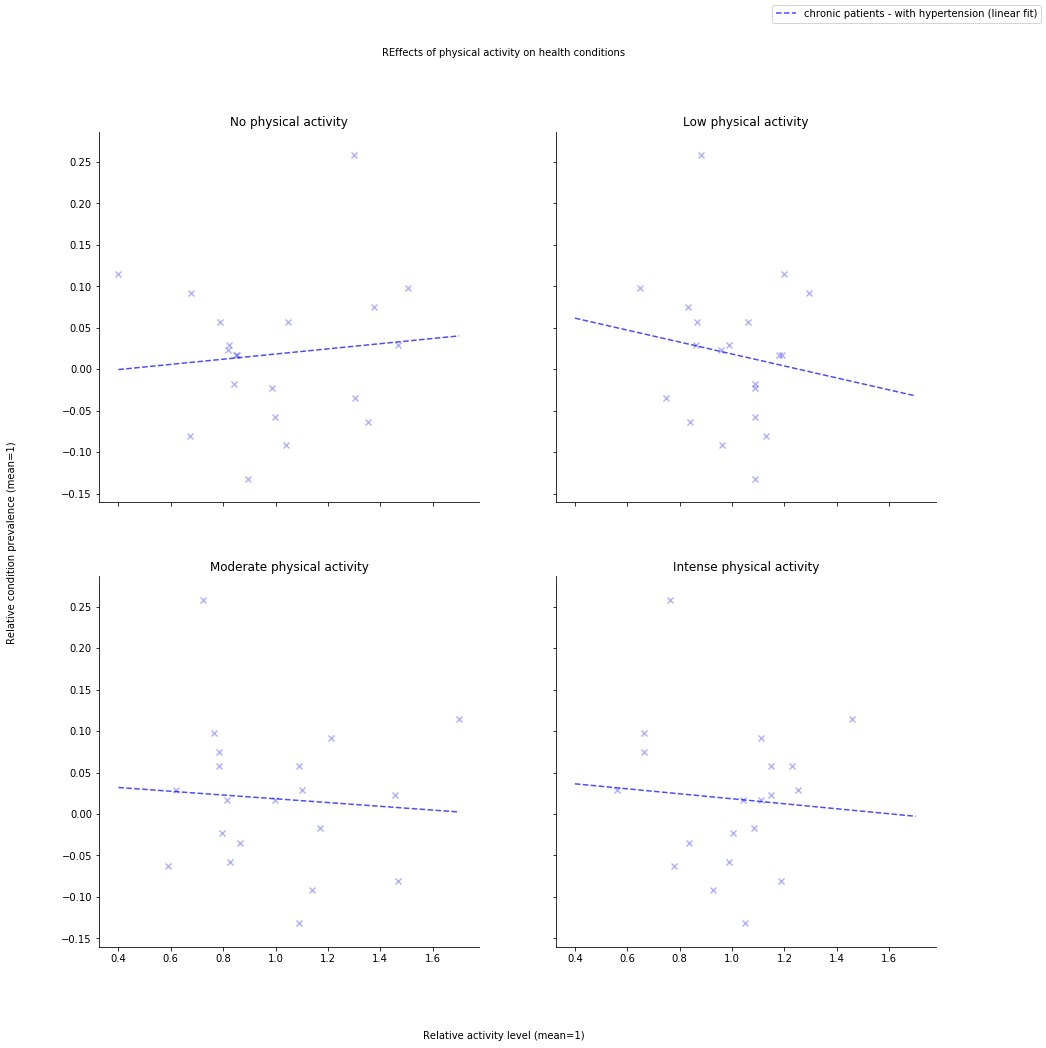

In [7]:
def fit_fn(x, y, order=1):
    fit = np.polyfit(x, y, order)
    return np.poly1d(fit) 

CONDITIONS_OF_INTEREST = [
#     'chronic patients - suffering from chronic bronchitis',
#     'persons  at least two chronic disease',
#     'chronic patients - with osteoporosis',
#     'chronic patients - suffering from allergic diseases',
#     'persons  in good health',
#     'persons  with chronic diseases in good health',
#     'chronic patients - suffering from osteoarthritis, arthritis',
    'chronic patients - with hypertension',
#     'persons  at least a chronic disease',
#     'chronic patients - suffering from gastric or duodenal ulcer',
#     'chronic patients - suffering from nervous disorders',
#     'chronic patients - suffering from heart disease',
#     'chronic patients - suffering from diabetes'
]
SPORT_LEVELS_OF_INTEREST = SPORT_LEVELS[:]

COLORS = ('blue', 'red', 'green', 'orange')

fig, axes = plt.subplots(
    2, 2,
    sharex=True,
    sharey=True,
    figsize=(15, 15)
)

axes = axes.ravel()

fig.text(0.5, 0.95, 'REffects of physical activity on health conditions', ha='center')
fig.text(0.5, 0.04, 'Relative activity level (mean=1)', ha='center')
fig.text(0.04, 0.5, 'Relative condition prevalence (mean=1)', va='center', rotation='vertical')

x_lim = df[SPORT_LEVELS_OF_INTEREST].values.min(), df[SPORT_LEVELS_OF_INTEREST].values.max()
y_lim = df[CONDITIONS_OF_INTEREST].values.min(), df[CONDITIONS_OF_INTEREST].values.max()

for ax_idx, (ax, sport_level) in enumerate(zip(axes, SPORT_LEVELS_OF_INTEREST)):
    
    ax.set_title(sport_level)
    
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    activity_level = df[sport_level].values

    for cnd_idx, condition in enumerate(CONDITIONS_OF_INTEREST):
        
        health = df[condition].values
        fit_function = fit_fn(activity_level, health)

        ax.scatter(
            activity_level, health,
            marker='x', c=COLORS[cnd_idx],
            alpha=0.3
        )
        
        x_lim_val = np.linspace(x_lim[0], x_lim[1], 20)
        ax.plot(
            x_lim_val, fit_function(x_lim_val), '--',
            color=COLORS[cnd_idx], alpha=0.7,
            label='{} (linear fit)'.format(condition) if ax_idx == 0 else None
        )
        
#         ax.text(x_lim[1], y_lim[1], '{:.3f}'.format(r2_score(health, fit_function(activity_level))))
#         ax.text(x_lim[1], y_lim[1] - 0.02, '{:.3f}'.format(fit_function[1]))
        
#         for idx, i in enumerate(activity_level):
#             ax.annotate(region[idx], (i, health[idx]))

fig.legend()

In [8]:
def fit_fn(x, y, order=1):
    fit = np.polyfit(x, y, order)
    return np.poly1d(fit)

SPORT_LEVELS_MULTI = ['{} Correlation'.format(sport_level) for sport_level in SPORT_LEVELS]

# Removing "healthy" status, not interesting
CONDITIONS_OF_INTEREST = HEALTH_CONDITIONS[[0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12]]

df_results = pd.DataFrame(columns=SPORT_LEVELS_MULTI, index=CONDITIONS_OF_INTEREST, dtype=np.float)

for sport_level in SPORT_LEVELS:

    activity_level = df[sport_level].values

    for cnd_idx, condition in enumerate(CONDITIONS_OF_INTEREST):
        
        health = df[condition].values
        fit_function = fit_fn(activity_level, health)
        health_pred = fit_function(activity_level)
        
        df_results.loc[
            condition,
            '{} Correlation'.format(sport_level)
        ] = fit_function[1]

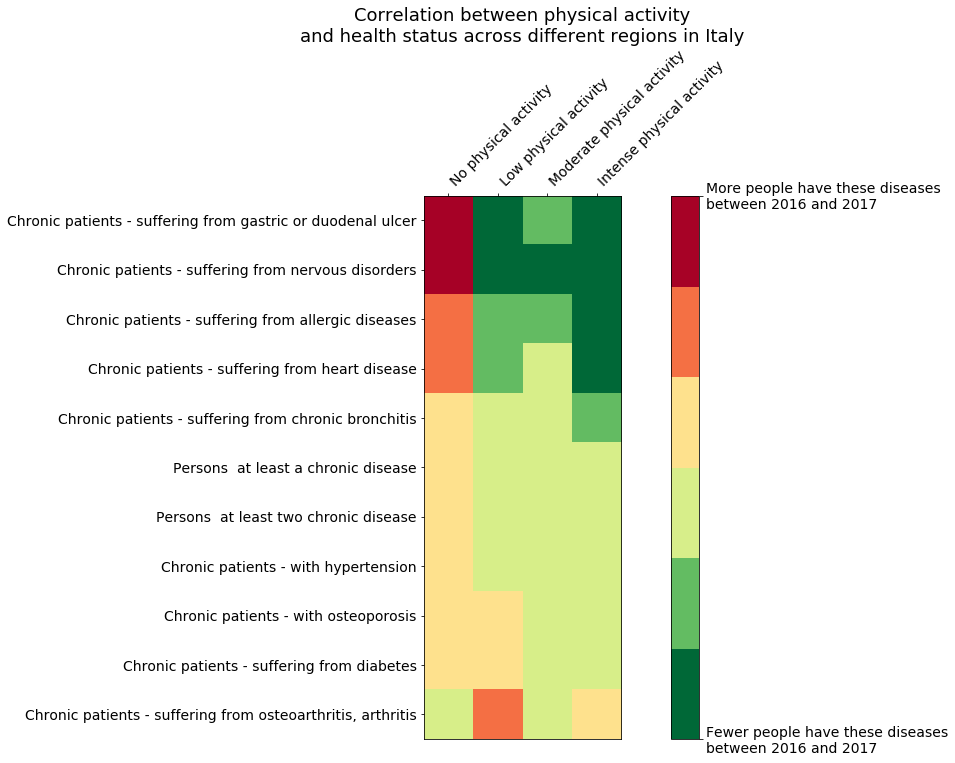

In [11]:

fig, axes = plt.subplots(1, 1, figsize=(18, 10))
fig.set_facecolor('white')
axes = [axes]
measures = ['Correlation']

results_split = [df_results[
        [c for c in df_results.columns if c.endswith(measure)]
].copy() for measure in measures]
results_split = [res.values for res in results_split]
# Sorting by strongest effect overall
sort = results_split[0].mean(axis=1).argsort() # By effect strength

results_split = [res[sort] for res in results_split]

# Color bar
linear_max = 0.5
cbar_limits = (
    (-linear_max, linear_max),
    (0, linear_max),
)

# results_split[0] *= results_split[1]

cbar_ticks = (
    ('Fewer people have these diseases\nbetween 2016 and 2017',
     'More people have these diseases\nbetween 2016 and 2017'),
    ('< {}'.format(cbar_limits[0][0]), '> {}'.format(cbar_limits[0][1])),
)

cmaps, norms = ['RdYlGn', 'BuPu'], []

for cmap_idx, color_map in enumerate(cmaps):
    cmap = getattr(plt.cm, color_map)
    bounds = np.linspace(cbar_limits[cmap_idx][0],cbar_limits[cmap_idx][1], 7)
    norms.append(BoundaryNorm(bounds, cmap.N))
    
    cmaplist = [cmap(i) for i in range(cmap.N, 0, -1)]
    cmaps[cmap_idx] = cmap.from_list('', cmaplist, cmap.N)


for ax_idx, ax in enumerate(axes):
    ax.set_facecolor('white')
    ax.set_title(
        'Correlation between physical activity\nand health status across different regions in Italy',
        fontsize=18)
    ax.set_xticks(range(len(df_results.columns)))
    ax.set_xticklabels([s.capitalize() for s in SPORT_LEVELS], rotation=45, ha='left', fontsize=14)
    ax.xaxis.tick_top()
    ax.set_yticks(range(len(df_results.index)))
    ax.set_yticklabels([s.capitalize() for s in df_results.index[sort]], fontsize=14)
    im = ax.imshow(results_split[ax_idx], cmap=cmaps[ax_idx], norm=norms[ax_idx])
    cbar = fig.colorbar(im, orientation='vertical', ticks=cbar_limits[ax_idx])
    cbar.ax.set_yticklabels(cbar_ticks[ax_idx], fontsize=14)